# Why did Billy Beane never win World Series? ML class project

I edited the code a little bit more after the presentation. I pulled some explanations and formulas too. At the end, it shows a multiple linear regression model that performed the best, and it choose the best 2 features, but as I presented, I think choosing 3 top features for predicting team average run scored, which is OBP (On Base Percentage), ISO (Isolated Power), and H(hits) is how baseball teams score. If you think about it, it intuitively makes sense, because first you need someone to get one base, and then you need a powerful hitter that will bring in that runner, and those three metric can describe this situation right now. It makes sense why they were the top 3 features for me.


Important thing to note here is that OPS and wRC+ was not the most important features. wRC+ was the fourth important feature, but it did not help with our linear regression of capturing more variance. This was shocking to me because wRC+ is one of the statistics that baseball commentators love to use when evaluating batters and how much they helped the team. Turns out, the wRC+ the stat itself is already a combination of linear models of other baseball stats that it wasn't the best to use it in our multiple linear regression model. I knew OPS wouldn't be helpful, because as I mention later on, OPS is a bogus statistics, adding batting average and non statistic value, and then slugging percentage, just mindlessly adding 3 stats and saying it is a good predictor.

I wish I had more time in presentation, and if I did, I wanted to say that if Billy Beane knew more about this data science, he would know now that he should've incorporated multiple linear regression, not only focusing on one statistics which was On Base Percentage (OBP), which turns out it was one of our top 2 features for predicting team run scored. It validates that we were on right track, and that they were on right track too, but came up short. Or maybe I shouldn't say they came up short, they still spent 1/6th of money per win than Yankees and won the division title, with players that everybody in baseball thought they were done for. That year's Oakland Atheletics 21win streak was one of the most historical moments in baseball also. I respect and pay tribute to a man Billy Beane, his assistant, and Bill James who tried to "solve" baseball with mathematics and statistics.

and this code is to convert the ipynb file in this google colab to html file, because without the all of actual 20 csv that I downloaded from fangraph, you won't be able to run any of this code.

In [ ]:
%%shell
jupyter nbconvert --to html /content/baseball_analytics_team_runs_scored_prediction-2.ipynb

[NbConvertApp] Converting notebook /content/baseball_analytics_team_runs_scored_prediction-2.ipynb to html
[NbConvertApp] Writing 1464157 bytes to /content/baseball_analytics_team_runs_scored_prediction-2.html


#  Data <a name="data"></a>
To perform the analysis, I've got (2000 ~ 2021 season) MLB team batting statistics data from [FanGraphs.com](https://www.fangraphs.com)

Fangraphs is one of the two most well known baseball statistics website along with Statcast that Heath is using for his batter analysis.

More about data features:
    
| **Metadata** | **Information** |
| :-----------: | :-----------: |
| **Origin of Data** | [FanGraphs.com](https://www.fangraphs.com) |
| **Terms of Service** | [Terms of Service](https://www.fangraphs.com/about/terms-of-service) |
| **Data Structure** | 22 datasets (**CSV** files) each of which consists of 30 rows * 23 columns |

| **Data Feature** | **Description** |
| :-----------: | :-----------: |
| **Season** | Each year refers to the corresponding season |
| **TEAM** | Team names |
| **G** | Total number of games played by all batters for each team |
| **PA** | [Plate Appearance](http://m.mlb.com/glossary/standard-stats/plate-appearance) |
| **AB** | [At-bat](http://m.mlb.com/glossary/standard-stats/at-bat) |
| **R** | [Runs Scored](http://m.mlb.com/glossary/standard-stats/run) |
| **H** | [Hit](http://m.mlb.com/glossary/standard-stats/hit) |
| **AVG** | [Batting Average](http://m.mlb.com/glossary/standard-stats/batting-average) |
| **OBP** | [On-base Percentage](http://m.mlb.com/glossary/standard-stats/on-base-percentage) |
| **SLG** | [Slugging Percentage](http://m.mlb.com/glossary/standard-stats/slugging-percentage) |
| **OPS** | [On-base Plus Slugging](http://m.mlb.com/glossary/standard-stats/on-base-plus-slugging) |
| **ISO** | [Isolated Power](http://m.mlb.com/glossary/advanced-stats/isolated-power) |
| **HR** | [Home run](http://m.mlb.com/glossary/standard-stats/home-run) |
| **BB** | [Walk](http://m.mlb.com/glossary/standard-stats/walk) |
| **SO** | [Strikeout](http://m.mlb.com/glossary/standard-stats/strikeout) |
| **SB** | [Stolen Base](http://m.mlb.com/glossary/standard-stats/stolen-base) |
| **CS** | [Caught Stealing](http://m.mlb.com/glossary/standard-stats/caught-stealing) |
| **wOBA** | [Weighted On-base Average](https://www.mlb.com/glossary/advanced-stats/weighted-on-base-average) |
| **wRC+** | [Weighted Runs Created Plus](https://www.mlb.com/glossary/advanced-stats/weighted-runs-created-plus) |
| **WAR** | [Wins Above Replacement](https://library.fangraphs.com/misc/war/) |

| **Newly Created Data** | **Description** |
| :-----------: | :-----------: |
| **League** | **AL**: American League / **NL**: National League |
| **Era** | Era segmentation |
| **TB** | [TB](https://www.mlb.com/glossary/standard-stats/total-bases) |

In [ ]:
# install packages
!pip install pingouin
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=f8339bf786affdadd4db7b213c9dc37070c56dd0bf55383224866bbfa5af0634
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# purpose of Analysis: predicting a team's runs scored based on various team batting statistics, just like Billy Beane
# load datasets
path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning CMU /TeamProject/mlb-team-batting-data/"
data_files = sorted([file for file in os.listdir(path)], reverse = True)

# empty dataframe
batting_df = pd.DataFrame()

# load data files one at a time and merge them into a single data frame, all 2000-2021 season team stats
for file in data_files:
    df = pd.read_csv(path + file)
    batting_df = pd.concat([batting_df, df])

# first five rows of data
batting_df.head(35)

,Season,Team,G,PA,AB,R,H,AVG,OBP,SLG,OPS,ISO,1B,2B,3B,HR,BB,SO,SB,CS,wOBA,wRC+,WAR
0,2021,TOR,2383,6070,5476,846,1455,0.266,0.330,0.466,0.797,0.200,895,285,13,262,496,1218,81,20,0.340,113,30.5
1,2021,HOU,2319,6291,5593,863,1496,0.267,0.339,0.444,0.783,0.177,962,299,14,221,569,1222,53,16,0.336,116,33.9
2,2021,BOS,2353,6122,5495,829,1434,0.261,0.328,0.449,0.777,0.188,862,330,23,219,512,1386,40,21,0.333,107,23.2
3,2021,SFG,2597,6196,5462,804,1360,0.249,0.329,0.440,0.769,0.191,823,271,25,241,602,1461,66,14,0.329,108,30.0
4,2021,CHW,2292,6084,5357,796,1373,0.256,0.336,0.422,0.758,0.166,886,275,22,190,586,1389,57,20,0.329,109,25.3
5,2021,CIN,2472,6162,5423,786,1352,0.249,0.328,0.431,0.759,0.182,822,295,13,222,553,1425,36,24,0.327,98,19.6
6,2021,LAD,2459,6239,5445,830,1330,0.244,0.330,0.429,0.759,0.185,822,247,24,237,613,1408,65,17,0.327,106,29.5
7,2021,WSN,2386,6113,5385,724,1388,0.258,0.337,0.417,0.754,0.159,914,272,20,182,573,1303,56,26,0.326,101,19.2
8,2021,ATL,2392,6056,5363,790,1307,0.244,0.319,0.435,0.754,0.191,779,269,20,239,549,1453,59,19,0.323,98,22.1
9,2021,TBR,2389,6213,5507,857,1336,0.243,0.321,0.429,0.750,0.186,790,288,36,222,585,1542,88,42,0.322,109,30.0


#  Data Cleaning <a name="data-cleaning"></a>
With the code below, here's what I did:
- Combined 22 different datasets (2000-2021 Season Team Batting Data) when loading 22 datasets.
- Renamed **R** data feature as **RS** for clarity.
- Created new data features: **League**, **Era** and **TB**
- Confirmed that there are no missing duplicated data.
- Converted **object** data types into **category** data types to save memory usage.
- Reordered data features.

In [ ]:
# 1. Data Cleaning
# rename specific column names
batting_df.rename(columns = {'R': 'RS'}, inplace = True)

# check missing data
print("Total number of missing values in each column:")
print(batting_df.isnull().sum())

# check duplicated data
print("Total number of duplicates in batting data: {}".format(batting_df.duplicated().sum()))

# create a new column for "Total Base (TB)" data
batting_df["TB"] = batting_df["1B"] + (2 * batting_df["2B"]) + (3 * batting_df["3B"]) + (4 * batting_df["HR"])

# export league data: National League (NL) / American League (AL)
nl_teams = ["ATL", "CHC", "CIN", "COL", "LAD",
            "MIL", "NYM", "PHI", "PIT", "SDP",
            "SFG", "STL", "ARI", "WSN", "FLA",
            "MIA", "MON"]
al_teams = ["MIN", "CHW", "CLE", "DET", "KCR",
            "TOR", "BAL", "BOS", "NYY", "OAK",
            "SEA", "TEX", "LAA", "TBR", "TBD",
            "ANA"]

# define leagues: NL / AL
def get_league(data):
    if data["Team"] in nl_teams:
        return "NL"
    elif data["Team"] in al_teams:
        return "AL"
    elif data["Team"] == "HOU" and data["Season"] <= 2012:
        return "NL"
    else:
        return "AL"

batting_df["League"] = batting_df.apply(lambda x: get_league(x), axis = 1)

# check data types
print(batting_df.dtypes)

# check memory usage
print("Total Memory Usage Before: {}".format(batting_df.memory_usage(deep = True).sum()))

# to save memory usage, change "League" and "Team" data type
batting_df["Team"] = batting_df["Team"].astype("category")
batting_df["League"] = batting_df["League"].astype("category")

print("Total Memory Usage After: {}".format(batting_df.memory_usage(deep = True).sum()))

# reorder data columns
cols = ["Season", "League"] + list(batting_df.columns)[1:-1]
batting_df = batting_df.reindex(columns = cols)

Total number of missing values in each column:
Season    0
Team      0
G         0
PA        0
AB        0
RS        0
H         0
AVG       0
OBP       0
SLG       0
OPS       0
ISO       0
1B        0
2B        0
3B        0
HR        0
BB        0
SO        0
SB        0
CS        0
wOBA      0
wRC+      0
WAR       0
dtype: int64
Total number of duplicates in batting data: 0
Season      int64
Team       object
G           int64
PA          int64
AB          int64
RS          int64
H           int64
AVG       float64
OBP       float64
SLG       float64
OPS       float64
ISO       float64
1B          int64
2B          int64
3B          int64
HR          int64
BB          int64
SO          int64
SB          int64
CS          int64
wOBA      float64
wRC+        int64
WAR       float64
TB          int64
League     object
dtype: object
Total Memory Usage Before: 205260
Total Memory Usage After: 131378


# EDA (Exploratory Data Analysis) <a name="eda"></a>
In this section, I'll statistically analyze the response variable: **Team Runs Scored (RS)** <br>


## How did the league average runs scored change over different eras

Let's see how the avg runs scored by the teams change over time, because I know that there are different eras in baseball. I am assuming Steroid era, post-steroid era, and launch angle era would show some difference? or maybe not maybe they all average out, let's see.

------- Yearly Changes in League Average Runs Scored -------
    Season     RS
0     2000  832.4
1     2001  773.3
2     2002  746.9
3     2003  765.9
4     2004  779.2
5     2005  744.2
6     2006  786.6
7     2007  777.4
8     2008  752.8
9     2009  747.3
10    2010  710.3
11    2011  693.6
12    2012  700.6
13    2013  675.2
14    2014  658.7
15    2015  688.2
16    2016  724.8
17    2017  752.7
18    2018  721.0
19    2019  782.2
20    2020  278.1
21    2021  733.7


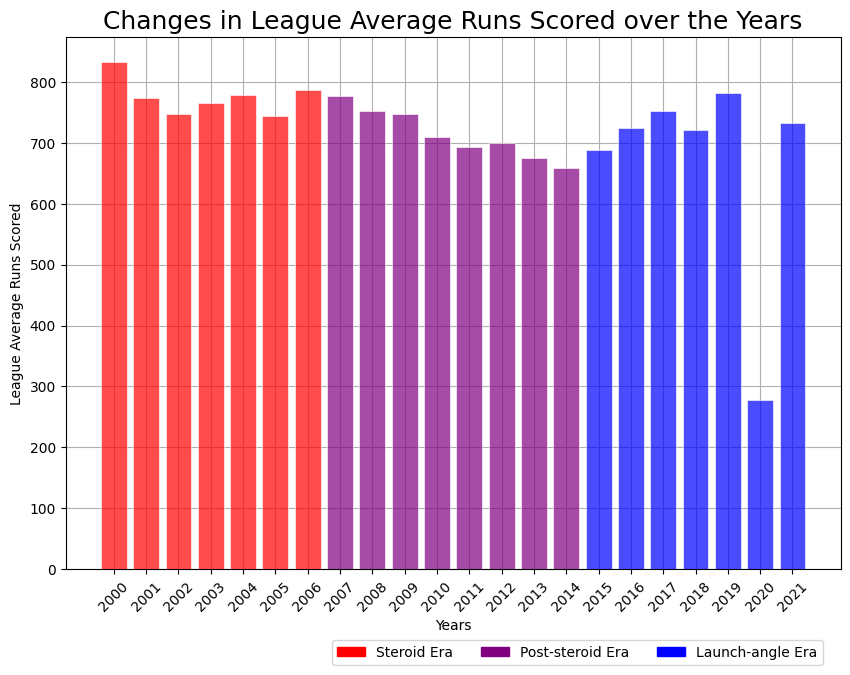

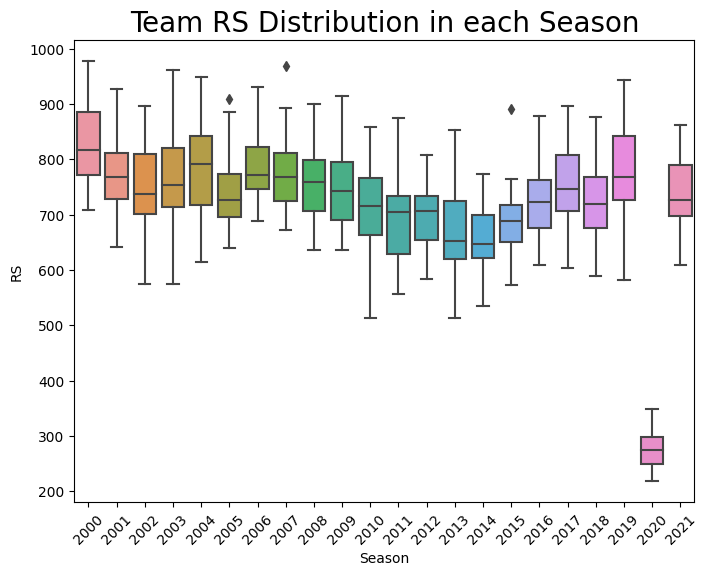

In [ ]:
season_df = batting_df.groupby("Season")
lg_avg_rs = season_df["RS"].mean().round(1).reset_index()
print("------- Yearly Changes in League Average Runs Scored -------")
print(lg_avg_rs)

# bar plot
values = np.array(lg_avg_rs["RS"])
idx = np.array(lg_avg_rs["Season"])
c1 = mpatches.Patch(color = "red", label = "Steroid Era")
c2 = mpatches.Patch(color = "purple", label = "Post-steroid Era")
c3 = mpatches.Patch(color = "blue", label = "Launch-angle Era")

fig, ax = plt.subplots(figsize = (10, 7))

plt.bar(idx, values, edgecolor = "white", linewidth = 0.6,
        color = ["red"] * 7 + ["purple"] * 8 + ["blue"] * 7,
        alpha = 0.7, zorder = 3)
plt.xticks(lg_avg_rs["Season"], rotation = 45)
plt.xlabel("Years")
plt.ylabel("League Average Runs Scored")
plt.title("Changes in League Average Runs Scored over the Years", fontsize = 18)
plt.legend(handles = [c1, c2, c3], ncol = 3,
           bbox_to_anchor= (0.66, -0.12), loc = "upper center")
plt.grid(zorder = 0)
fig.subplots_adjust(bottom = 0.12)
plt.show()

# box plot
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(x = "Season", y = "RS", data = batting_df, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title("Team RS Distribution in each Season", fontsize = 20)
plt.show()

The bar plot and box plot above show how the **league median RS** changed over time since 2000. As we can see, although there were slight fluctuations, *teams were able to score relatively many runs up until the mid 2000's (2000 ~ 2006) on average*.

However, such a trend seemed to reverse after the 2006 season. For some reason, *there was a clear downward trend in the league median RS until 2014 season*. Then *it has been increasing again since 2015 except one weird season: 2020*. <br>
Like I said earlier, I would say that is because of statcast era showing that launch angle is important to hitting, that changed all of batting mechanism til now.

Note that the 2020 season was **an abnormal 60-game season** due to the pandemic, while teams usually play 162 games in a normal season.


### Era segmentation
To perform one-way ANOVA, I first segmented seasons. <br>
For many baseball fans, it's well-known that the MLB history is segmented into several eras based on **Runs Scored environment changes** that correspond with external factors, such as changes in rules/balls, PEDs abuse, etc. Some examples are: <br>
- MLB players abused PEDs since the mid 1990's up until the mid 2000's - **Steroid Era**.
- After the drug scandal, MLB's drug testing and penalties became strict to prevent players from being helped by PEDs - **Post-steroid Era**.
- With the help of a new technology, **Statcast**, sabermetricians found that if hitters hit try to hit fly balls rather than ground balls by increasing their [lauch angles](https://www.mlb.com/glossary/statcast/launch-angle), it increases the chances of hitting home runs - **Fly-ball Revolution Era**. <br>

Since the bar plot above also captures the reality, I segmented seasons on the basis of the corresponding RS environment observed from the bar plot above.<br>
The era segmentation was done as follows:

| **Season** | 2000 - 2006 | 2007 - 2014 | 2014 - 2021 |
| :-----------: | :-----------: | :-----------: | :-----------: |
| **Era** | Steroid Era | Post-steroid Era | Fly-ball Revolution Era |

In [ ]:
# divide seasons into "Era" groups
def get_era(data):
    if data["Season"] <= 2006:
        return "Steroid Era"
    elif data["Season"] > 2006 and data["Season"] <= 2014:
        return "Post-steroid Era"
    else:
        return "Fly-ball Revolution Era"

batting_df["Era"] = batting_df.apply(lambda x: get_era(x), axis = 1)
batting_df["Era"] = batting_df["Era"].astype("category")

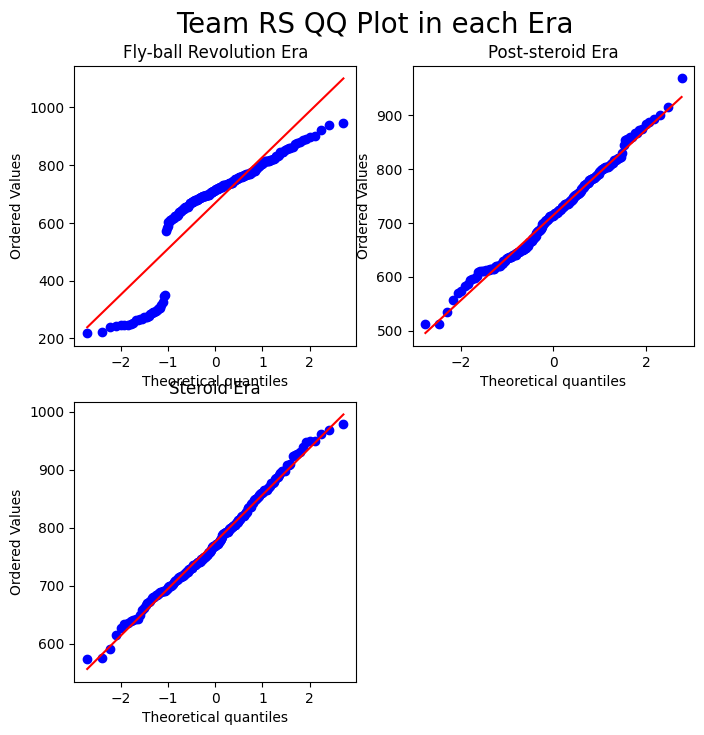

In [ ]:
# check one-way ANOVA assumptions
# normality
eras = batting_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(batting_df.loc[batting_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
    ax.set
fig.suptitle("Team RS QQ Plot in each Era", fontsize = 20, y = 0.95)
plt.show()

Seems like the 2020 season really alters the data, as expected, so I will not use 2020 season data from now on.

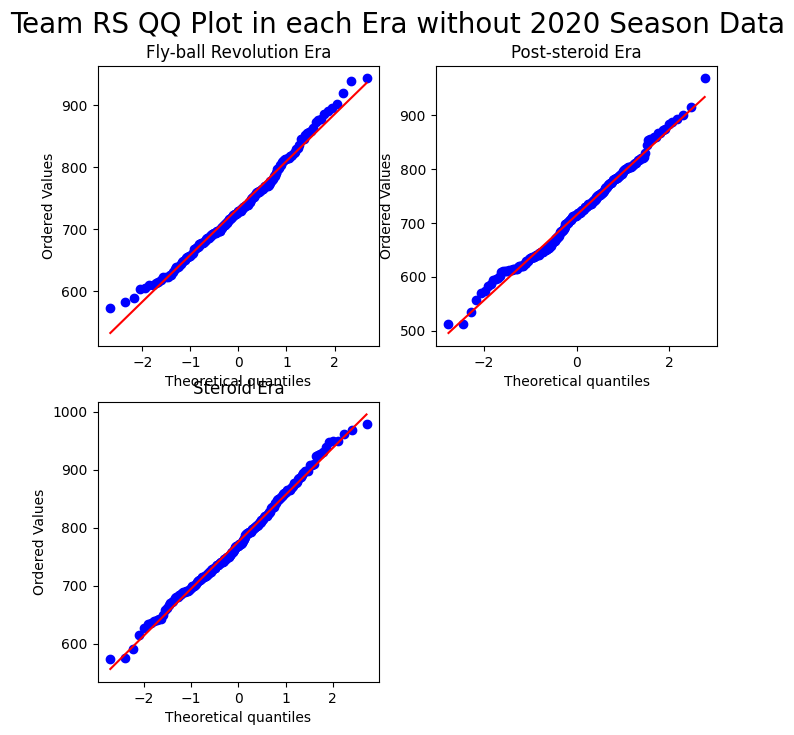

------- Team Runs Scored Descriptive Statistics by Era -------
                         count        mean        std    min     25%    50%     75%    max
Era                                                                                       
Fly-ball Revolution Era  180.0  733.777778  75.455974  573.0  682.75  729.0  777.25  943.0
Post-steroid Era         240.0  714.479167  79.132956  513.0  650.00  714.5  770.00  968.0
Steroid Era              210.0  775.509524  80.319651  574.0  718.25  768.5  826.75  978.0


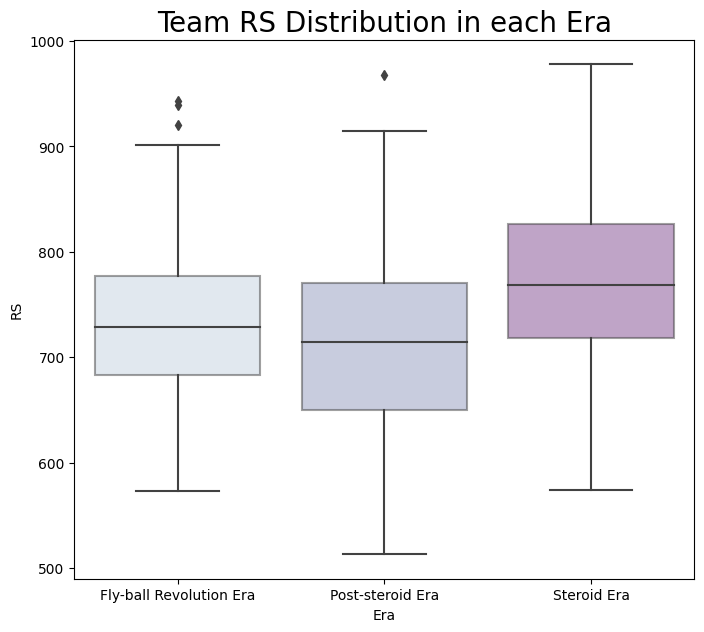

In [ ]:
# since Fly-ball Era "RS" are not normally distributed due to 2020 season data,
# drop 2020 season data (abnormal 60-game season = outliers)
batting_df = batting_df.loc[batting_df["Season"] != 2020]

# check the normality assumption again
eras = batting_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(batting_df.loc[batting_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
fig.suptitle("Team RS QQ Plot in each Era without 2020 Season Data", fontsize = 20, y = 0.95)
plt.show()

# equal-variance
# descriptive statistics
era_df = batting_df.groupby("Era")
rs_sum_era = era_df["RS"].describe()
print("------- Team Runs Scored Descriptive Statistics by Era -------")
print(rs_sum_era.to_string())

# box plot
fig, ax = plt.subplots(figsize = (8, 7))

sns.boxplot(x = "Era", y = "RS", data = batting_df, ax = ax,
            palette = "BuPu", boxprops = dict(alpha = 0.5))
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title("Team RS Distribution in each Era", fontsize = 20)
plt.show()

# Feature Selection <a name="feature-selection"></a>
In this section, I'll focus on feature selection and see what are the best predictor for our response variable average run scored for teams. <br>
The initial number of (*numerical*) independent variables is 22


Initial total number of numerical independent variables: 22


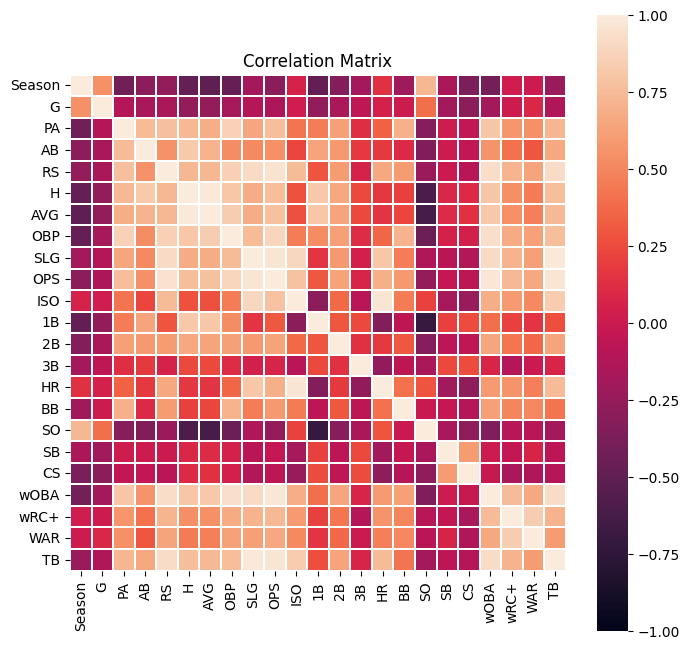

In [ ]:
# initial total number of numerical independent variables (i.e., except the response variable "RS")
init_var_num = len(batting_df.select_dtypes(exclude = "category").columns)
print("Initial total number of numerical independent variables: {}".format(init_var_num - 1))

# correlation matrix
corrMatrix = batting_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

sns.heatmap(corrMatrix, square = True, linewidths = 0.3, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

###  Multicollinearity
Looking at the correlation heatmap above, some independent variables are highly correlated with each other, which may potentiallly cause multicollinearity when building a multiple linear regression model.

Say, you included all independent variables available in your multiple linear regression model. If independent variables $x_1$ and $x_2$ are highly correlated with each other, then estimated coefficients (slopes $\beta_1$ and $\beta_2$) can be very sensitive to small changes in either $x_1$ or $x_2$ reducing the precision of estimated coefficients of your model.

Let's first filter some of these independent variables based on **the correlation between independent variables and RS**.

In [ ]:
# 3-1. first drop variables that have lower (absolute) correlations with 'RS' than 0.65
corrMatrix = abs(batting_df.corr())
cols = list(corrMatrix.columns)
vars_to_drop = []
for col in cols:
    if corrMatrix[col]['RS'] < 0.65:
        vars_to_drop.append(col)

filtered_df = batting_df.loc[:, ~batting_df.columns.isin(vars_to_drop)]
filtered_vars = list(filtered_df.select_dtypes(exclude = "category").columns)
print(filtered_vars)

['PA', 'RS', 'H', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'HR', 'wOBA', 'wRC+', 'TB']


After filtering variables whose absolute correlation with RS is less than 0.65, we have **12 predictors**. <br>
Now let's have a look at *pairwise correlations* between independent variables. This time, I'll exclude independent variables that have **high pairwise correlations**.

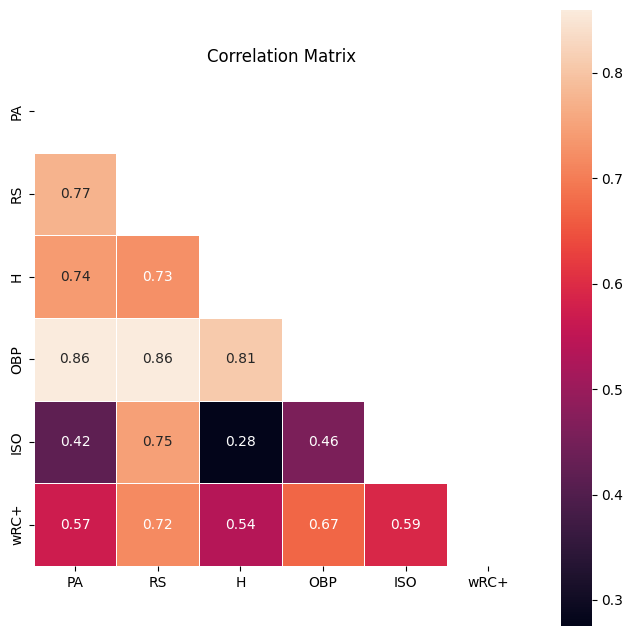

In [ ]:
# 3-2. drop any independent variables if its pairwise correlation between other independent variables is higher than 0.9
ind_vars_df = filtered_df.iloc[:, filtered_df.columns != 'RS']

corrMatrix = abs(filtered_df.corr())
upperTri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
vars_to_drop = [col for col in upperTri.columns if any(upperTri[col] >= 0.9)]
filtered_df.drop(vars_to_drop, axis = 1, inplace = True)

# new correlation matrix for filtered data features
new_corr = filtered_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

mask = np.triu(np.ones_like(new_corr))
sns.heatmap(new_corr, mask = mask, square = True, linewidths = 0.5, annot = True, annot_kws = {'size': 10},
            xticklabels = new_corr.columns, yticklabels = new_corr.columns)
plt.title('Correlation Matrix')

plt.show()

# Feature Selection and seeing how each feature helps the model

After we consider high pairwise correlations between independent variables, we ended up **5 predictors**. Now, we should be able to see what are the best predictors and rank them and see how each of them contribute to our model.

It is right here where I was playing around, choosing top 2, top 3, top 4, top 5 features and seeing actually how much does it help our multiple linear regression model. I think choosing the top 3 predictor, OBP, ISO, H makes the most intuitive sense, and also the R-squared and adjusted R-squared value do not change after the top 3 either, at 0.913, which is pretty good number for explaining the variance in team run scored.

In [ ]:
# 3-3. Recursive Feature Elimination
# select numerical data
num_df = filtered_df.select_dtypes(exclude = "category")
x = num_df.loc[:, num_df.columns != 'RS']
y = num_df['RS']
cols = list(x.columns)

model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 3, verbose = 2)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars))

Fitting estimator with 5 features.
Fitting estimator with 4 features.
RFE Features: ['H', 'OBP', 'ISO']


According to RFE, the best two predictors are: **OBP** and **ISO**. Seems like the third best predictor is **H** which is for hits. Not homeruns, hits.

To validify the result, let's check out **Variance Inflation Factor (VIF)** scores.

In [ ]:
# check VIF
x = num_df[selected_vars]
x = sm.add_constant(x)
y = num_df['RS']

lm = sm.OLS(y, x)
result_rs = lm.fit()
print(result_rs.summary())

vif = pd.DataFrame()
vif['Feature'] = lm.exog_names
vif['VIF'] = [variance_inflation_factor(lm.exog, i) for i in range(lm.exog.shape[1])]
print(vif[vif['Feature'] != 'const'])

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2184.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:02:19   Log-Likelihood:                -2905.8
No. Observations:                 630   AIC:                             5820.
Df Residuals:                     626   BIC:                             5837.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -734.7381     22.658    -32.428      0.0

The VIF score of 1.269 suggests that there is a low level of multicollinearity! Likewise, both predictors are considered significant as their t-statistics are large resulting in approximate p-values of 0.

With these two predictors, let's build a multiple linear regression model splitting the data into training and test data sets to prevent overfitting data.

#  Multiple Linear Regression <a name="mlr"></a>
With the selected features **OBP** and **ISO** above, I'll now build a multiple linear regression model with 80-20 split



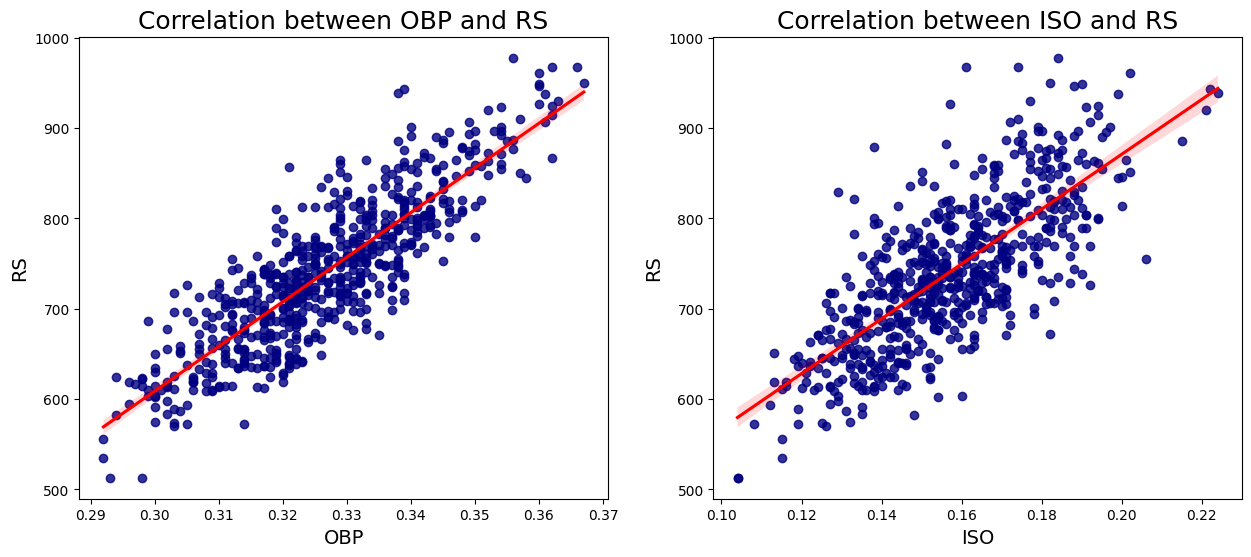

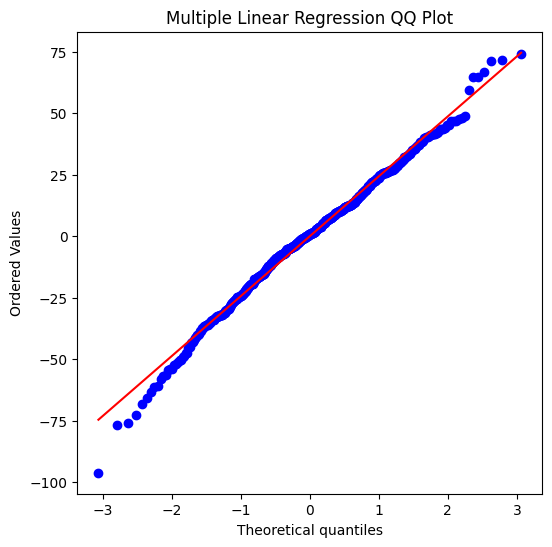

In [ ]:
# select final features for multiple linear regression model
mlr_df = batting_df.loc[:, ["RS", "OBP", "ISO"]]

# linearity
# scatter plots
cols = list(mlr_df.drop('RS', axis = 1).columns)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

for col, ax in zip(cols, axes.flatten()[:2]):
    sns.regplot(x = col, y = 'RS', data = mlr_df, scatter_kws = {'color': 'navy'},
                line_kws = {'color': 'red'}, ax = ax)
    ax.set_title('Correlation between {} and RS'.format(col), fontsize = 18)
    ax.set_xlabel(col, fontsize = 14)
    ax.set_ylabel('RS', fontsize = 14)

plt.show()

# homoscedasticity
# residual plot
model = linear_model.LinearRegression().fit(x, y)
fitted_y = model.predict(x)
resid = fitted_y - y

# fig = plt.subplots(figsize = (10, 6))
# sns.residplot(fitted_y, "RS", data = resid, lowess = True,
#               scatter_kws = {"alpha": 0.5}, line_kws = {"color": "red", "lw": 1})
# plt.xlabel("Fitted values", fontsize = 14)
# plt.ylabel("Residuals", fontsize = 14)
# plt.title("Residuals vs Fitted", fontsize = 20)
# plt.show()

# normality
# QQ plot
fig = plt.subplots(figsize = (6, 6))
stats.probplot(resid, dist = "norm", plot = plt)
plt.title("Multiple Linear Regression QQ Plot")
plt.show()

In [ ]:
mlr_df.head(10)

,RS,OBP,ISO
0,846,0.330,0.200
1,863,0.339,0.177
2,829,0.328,0.188
3,804,0.329,0.191
4,796,0.336,0.166
5,786,0.328,0.182
6,830,0.330,0.185
7,724,0.337,0.159
8,790,0.319,0.191
9,857,0.321,0.186


## Model Interpretation
The final multiple linear regression model is:
$$\hat{{Team RS}}=-774.43+3766.41(\text{Team OBP})+1815.95(\text{Team ISO})$$
- **OBP**: a one unit increase in team **OBP** results in a 3766.41 increase in team RS *holding team ISO constant* <br>
 Given OBP always lies between 0 and 1 (just like a probability), more realistic interpretation would be: **a 0.01 increase in team OBP** results in an approximte **37.66 increase in team RS**

- **ISO**: a one unit increase in team **ISO** results in a 1814.95 increase in team RS *holding team OBP constant* <br>
 As with OBP, more realistic interpretation would be: **a 0.01 increase in team ISO** results in an approximte **18.15 increase in team RS**

## Model Evaluation
When evaluating a linear regression model, there are several metrics that we can refer to.
###  R-squared

 According to the model result, our model that consists of team **OBP** and **ISO** can explain approximately **90.3% of the total variation in team RS**, which is pretty decent!

###  RMSE (Root Mean Squared Error)

According to our model, **the RMSE of 25.11** is small enough given that the range of team RS is 465 without abnormal 2020 season data.

###  MAE (Mean Absolute Error)

As we can see, MAE measures **the average sum of the absolute residuals**, which ignores the direction of residuals. Therefore, it's *less influenced by outliers*.

 The MAE of our model is about **19.16**, which is pretty small given that teams play 162 games in a regular season. <br>
So if devide 19.16 by 162, the average sum of the absolute errors *per game* will be about **0.12 runs**!



#  Model Validation <a name="model-validation"></a>
I'll perform **10-fold cross-validation** on model.

## Multiple Linear Regression 10-fold Cross-validation

In [ ]:
# 10-Fold Cross-validation for the multiple linear regression model
model = LinearRegression()
x = filtered_df[['OBP', 'ISO']]
y = filtered_df['RS']

cv_r2 = cross_val_score(model, x, y, scoring = "r2", cv = 10)
cv_rmse = -1 * cross_val_score(model, x, y, scoring = "neg_root_mean_squared_error", cv = 10)
cv_mae = -1 * cross_val_score(model, x, y, scoring = "neg_mean_absolute_error", cv = 10)

print("------- Multiple Linear Regression Cross-Validation -------")
print("Mean R-squared: {}".format(cv_r2.mean()))
print("Mean RMSE: {}".format(cv_rmse.mean()))
print("Mean MAE: {}".format(cv_mae.mean()))

------- Multiple Linear Regression Cross-Validation -------
Mean R-squared: 0.8577208614156632
Mean RMSE: 26.855306313446953
Mean MAE: 21.19774026994056


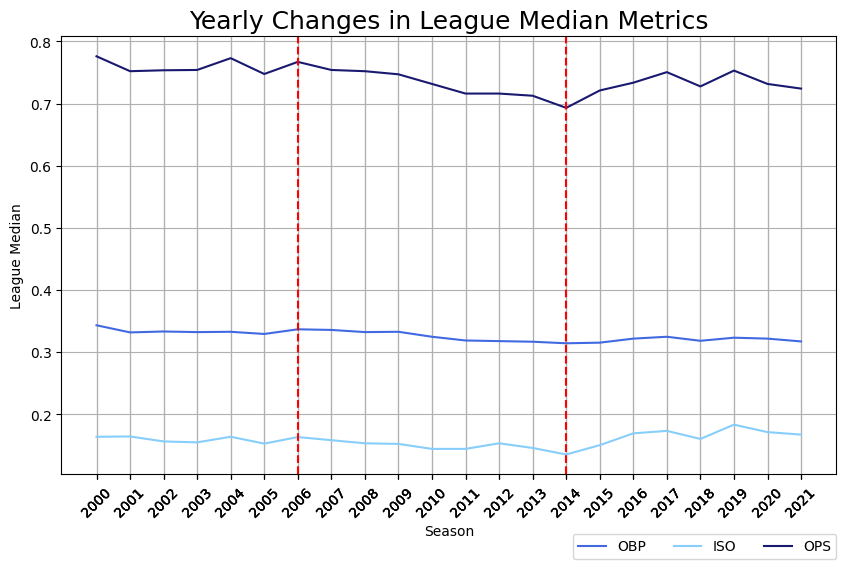

In [ ]:
# compare how league median "OBP", "ISO", and "OPS" changed over time
median_metrics = season_df[["OBP", "ISO", "OPS"]].median().reset_index()
melted_df = median_metrics.melt("Season", var_name = "Metrics", value_name = "League Median")

fig, ax = plt.subplots(figsize = (10, 6))

sns.lineplot(x = "Season", y = "League Median", hue = "Metrics", data = melted_df,
             palette = ["royalblue", "lightskyblue", "midnightblue"])
plt.xticks(melted_df["Season"], rotation = 45)
plt.title("Yearly Changes in League Median Metrics", fontsize = 18)
plt.legend(bbox_to_anchor= (0.83, -0.12), loc = "upper center", ncol = 3)
plt.axvline(x = 2006, color='red', linestyle = "--")
plt.axvline(x = 2014, color='red', linestyle = "--")
plt.grid()
fig.subplots_adjust(bottom = 0.15)
plt.show()

Note that the Y-axis represents the league *median* values of the corresponding team batting metrics. The reason I used median intead of mean is to remove the impact of outliers. <br>
While both leauge median **OBP** and **ISO** stayed constant over the past 20 years, league median **OPS** seemed to vary from era to era.

What's interesting about this line plot is that the historical changes in league median OPS matches historical changes in league average RS that we've observed from the bar plot as previosuly. The common trends are:
- **Steroid Era**: During the steroid era, teams achieved the highest team OPS and RS ever since 2000.
- **Post-steroid Era**: Then teams' overall offensive ability (OPS and RS) kept decreasing uptil 2014.
- **Fly-ball Revolution Era**: After the 2014 season, teams seemed to recover their offensive ability.

### Important Note
Note that the names of era segmentation came from common knowledge in MLB, and thus, they have nothing to do with any causal relationships between the names of era and the changes/trends in league average runs scored. <br>
That is to say, although 2000-2006 seasons were grouped into Steroid Era, **it doesn't mean** steroids and other PEDs certainly helped teams score many runs **nor** the hitter-friendly RS environment during the early 2000's is attributable to steroids. <br>
Likewise, we cannot conclude that the decreases in league median OPS and average RS resulted from strengthened drug testings and penalties. (after the [Mitchell report](https://en.wikipedia.org/wiki/Mitchell_Report) released in 2007) <br>
Therefore, finding out what factors affected such changes in teams' offensive abilities requires further thorough research.

#  Conclusion <a name="conclusion"></a>
In the early 2000's, there was an important move toward how baseball operations should understand baseball with the help of statistics and new technologies in MLB. As a result, some old-fashioned and conventional baseball wisdoms/strategies were proven to be wrong by sabermetricians. They tried to statistically analyze baseball to provide teams with more efficent ways of winning the ball game **by minimizing the costs of wins**. <br>
This is what we know from the book and movie: **[Moneyball](https://www.imdb.com/title/tt1210166/)**.

In this notebook, I revisited Moneyball to figure out what makes team win in baseball in terms of teams' offesive ability: **Team Runs Scored**.

Some findings are:
### EDA
- There were statistically significant historical changes in the league average RS. That is, **Era** segmentation was a significant factor that affected the league average RS.

- Apart from **Era**, **League** (American League vs National League to which teams belong) was another significant factor that affected the league average RS and it was proven that American League teams scored slightly more runs than National League teams over the past 20 years (i.e., AL was a more hitter-friendly league than NL)

- Nevertheless, no interaction effect bewteen **Era** and **League** was found.

### Regression
- In the multiple linear regression model, both team **OBP** and **ISO** were selected as the two most significant predictors for team RS prediction. Such a regression model explained approximately 85.8% of total variations in team RS with an RMSE of 26.86 and MAE of 21.20 (through 10-fold cross-validation).

- In the simple linear regression model, team **OPS** was used as the single best predictor to estimate team RS. It explains approximately 87.1% of total variations in team RS with an RMSE of 25.48 and MAE of 19.79 (trhough 10-fold cross-validation).

- As the simple linear regressino model predicts team RS slightly better with a fewer number of predictors, the simple linear regression model is considered a better model to make predictions about team RS than the multiple linear regression model.

### OBP, ISO and OPS
For those of you who are not familiar with baseball, let's talk more about what those three predictors actually measure in baseball.

#### OBP (On-base Percentage)
As the name suggests, OBP is simply **the probability that a batter reaches base per plate appearances**. For example, if a batter hit 2 home runs, 1 single and walked twice (i.e., two [base-on balls](https://www.mlb.com/glossary/standard-stats/walk)) in 10 plate appearances, his OBP is 0.500. Essentially it measures how frequently batters/teams reach bases per plate appearances.

#### ISO (Isolated Power)
Isolated power is calculated as follows: $\text{Slugging Percentage}-\text{Batting Average}$. <br>
Without having to understand what slugging percentage and batting average are, ISO quantifies **the raw power of a batter** by taking into account *extra-base hits (i.e, 2B, 3B and Home Runs)*. That is, it measures *a hitter's ability to advance base runners* who has reached bases ahead of his plate appearance.

#### OPS (On-base Plus Slugging)
OPS is the sum of **OBP** and **[SLG](https://www.mlb.com/glossary/standard-stats/slugging-percentage)**. We now know what OBP is but what's SLG? SLG is a hitting metric that gives different credits/weights to [1B](https://www.mlb.com/glossary/standard-stats/single), [2B](https://www.mlb.com/glossary/standard-stats/double), [3B](https://www.mlb.com/glossary/standard-stats/triple) and [HR](https://www.mlb.com/glossary/standard-stats/home-run). <br>
The formula is: $\text{SLG}=\frac{\text{1B} \ + \ \text{2B} \ ×\ 2 \ + \ \text{3B} \ ×\ 3 \ + \ \text{HR} \ ×\ 4}{\text{At-bats}}$. Basically it measures how a hitter contributed to his team by giving different weights/credits to various hitting events that he made.

Therefore, if we sum OBP and SLG, we obtain **OPS**, which quantifies a hitter's ability to reach bases (OBP) and to hit extra-base hits (2B, 3B, and HR) with different weights (SLG).

I said this in presentation too. Technically, OPS is an imperfect way to measure a batter's (or team's) offesive ability as it has several drawbacks. <br>
First, while OBP is a probability, SLG is not a probability (it can exceed 1). Thus, mathematically, it makes no sense to sum a probability and non-probability. Second, the different weights assigned to different hitting events (i.e., 1 for 1B, 2 for 2B, 3 for 3B, 4 for HR) in SLG are proven to be overestimated. For this reason, most sabermetricians argue that OPS is relatively less accurate than other advanced hitting metrics.

### How a team scores runs in baseball?
After understanding what each of these metrics measure in baseball, we're now in a better position to understand the multiple and simple linear regression model that we built above. The nature of baseball: How does a team run score in baseball? <br>
First, batters need to reach bases. Then the next batters must advance the hitters who has reached bases earlier (i.e., baserunners). If a baserunner reaches home plate going through the first, second and third base, your score one run.

This is how a baseball team scores runs. It's fixed. There's no other way of scoring runs in baseball. (Note that a hitter reaches bases, advance and bring himself home through a home run).

Let's think about our **multiple linear regression model**:

$$\hat{{Team RS}}=-774.43+3766.41(\text{Team OBP})+1815.95(\text{Team ISO})$$

As I said, **OBP** measures *how frequently a batter reaches bases*, while **ISO** quantifies the raw power of a hitter by taking into account extra-base hits (2B, 3B, and HR) that *advances baserunners*. It sounds like the multiple linear regression is a quantified formula of how a team score runs in baseball, although it's not perfect (as there's no perfect model in statistics).

